In [55]:
using AbstractFFTs
using CairoMakie
using FourierFlows
using Printf
using JLD2
using Printf
using LinearAlgebra: ldiv!
include("../RSWUtils.jl")

function hann(L)
    ell = L + 1
    N = ell - 1
    n = 0:N
    w = @. 0.5 * (1 - cos.(2*π*n/N))
    return w[1:end-1]
end

function demean(data)
    mean = sum(data, dims=1) / size(data, 1)
    return data .- mean
end

function linear_least_squares(t, data)
    tsum = sum(t)
    t2sum = sum(t.^2)
    txsum = sum(t .* data, dims=1)
    N = size(t,1)
    slope = (N * (txsum)) / (N * t2sum - tsum.^2)
    intercept = -slope * tsum / N
    return (slope, intercept)
end

function detrend(t, data)
    m, b = linear_least_squares(t, demean(data))
    return data .- m .* t .- b
end

function clean_fft(t, data, window)
    clean_data = detrend(t, data)
    return fft(window .* clean_data, 1)
end

function set_up_grid(directory)
    setup_file = jldopen(@sprintf("%s/rsw.%06d.jld2", directory, 0), "r")
    nx = setup_file["grid/nx"]
    ny = setup_file["grid/ny"]
    println(nx)
    Lx = setup_file["grid/Lx"]
    Ly = setup_file["grid/Ly"]
    close(setup_file)
    grid = TwoDGrid(CPU(); nx, Lx, ny, Ly, aliased_fraction=0, T=Float64)
    return grid
end

function set_up_params(directory)
    setup_file = jldopen(@sprintf("%s/rsw.%06d.jld2", directory, 0), "r")
    f = setup_file["params/f"]
    Cg2 = setup_file["params/Cg2"]
    close(setup_file)
    return (; f, Cg2)
end

function get_total_frames(directory, file_indices)
    total_frames = 0
    
    file_list = file_indices
    for i=file_list
        file = jldopen(@sprintf("%s/rsw.%06d.jld2", directory, i))
        println(file)
        frames = keys(file["snapshots/t"])
        total_frames += length(frames)
        close(file)
    end
    return total_frames
end

function get_fourier_data(directory, file_indices, k_idx, l_idx)
    grid = set_up_grid(directory)
    params = set_up_params(directory)
    file_list = file_indices
    total_frames = get_total_frames(directory, file_indices)
    window = hann(total_frames)

    println("Starting...")
    flush(stdout)
    #output_file = jldopen("radial_data.jld2", "w")
    kr = grid.kr
    dk = grid.kr[2] - grid.kr[1]
    t = zeros(total_frames)
    C₀ = zeros(Complex{Float64}, total_frames)
    C₊ = zeros(Complex{Float64}, total_frames)
    C₋ = zeros(Complex{Float64}, total_frames)

    Φ₀, Φ₊, Φ₋ = compute_balanced_wave_bases(grid, params)
    
    println("k=" * string(k_idx))
    flush(stdout)
    base_index = 0
    for i=file_list
        file = jldopen(@sprintf("%s/rsw.%06d.jld2", directory, i), "r")
        frames = keys(file["snapshots/t"])
        for frame_idx=1:length(frames)
            frame_key = frames[frame_idx]
            t[base_index + frame_idx] = file["snapshots/t/" * frame_key]
            snapshot = file["snapshots/sol/" * frame_key]

            uh = @views snapshot[:,:,1]
            vh = @views snapshot[:,:,2]
            ηh = @views snapshot[:,:,3]
            (ugh, vgh, ηgh), (uwh, vwh, ηwh) = wave_balanced_decomposition(uh, vh, ηh, grid, params)
            c₀, c₊, c₋ = compute_balanced_wave_weights(uh, vh, ηh, Φ₀, Φ₊, Φ₋)
            C₀[base_index+frame_idx] = c₀[k_idx, l_idx]
            C₊[base_index+frame_idx] = c₊[k_idx, l_idx]
            C₋[base_index+frame_idx] = c₋[k_idx, l_idx]
        end
        close(file)
        base_index += length(frames)
    end
    return t, C₀, C₊, C₋
end

get_fourier_data (generic function with 1 method)

In [56]:
t, c0, cp, cn = get_fourier_data("/scratch/nad9961/rsw/57233890/6", 0:34, 7, 12)

512
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000000.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000001.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000002.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000003.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000004.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000005.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000006.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000007.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000008.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000009.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000010.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000011.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000012.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.000013.jld2 (read-only)
JLDFile /scratch/nad9961/rsw/57233890/6/rsw.

([0.0, 2118.647216796875, 2118.674560546875, 2118.701904296875, 2118.729248046875, 2118.756591796875, 2118.783935546875, 2118.811279296875, 2118.838623046875, 2118.865966796875  …  2213.912841796875, 2213.940185546875, 2213.967529296875, 2213.994873046875, 2214.022216796875, 2214.049560546875, 2214.076904296875, 2214.104248046875, 2214.131591796875, 2214.158935546875], ComplexF64[-2456.6904283922513 - 3259.1841791937472im, 38.476466303377606 - 92.03786549150723im, 38.710472418663386 - 96.0784650235943im, 39.28169089205792 - 100.02247904232102im, 40.12529071904734 - 103.72870871435782im, 41.1471949072036 - 107.05613477808957im, 42.23218220524248 - 109.87454156052084im, 43.251918513691294 - 112.07489154848929im, 44.07774619401039 - 113.58526030342567im, 44.58755094929008 - 114.37437163213029im  …  117.55345371317955 + 26.984767865297478im, 113.91928539415447 + 26.070068404949964im, 110.46483017710071 + 25.449671820160784im, 107.21405438625482 + 25.054586842749742im, 104.16852397677926 + 

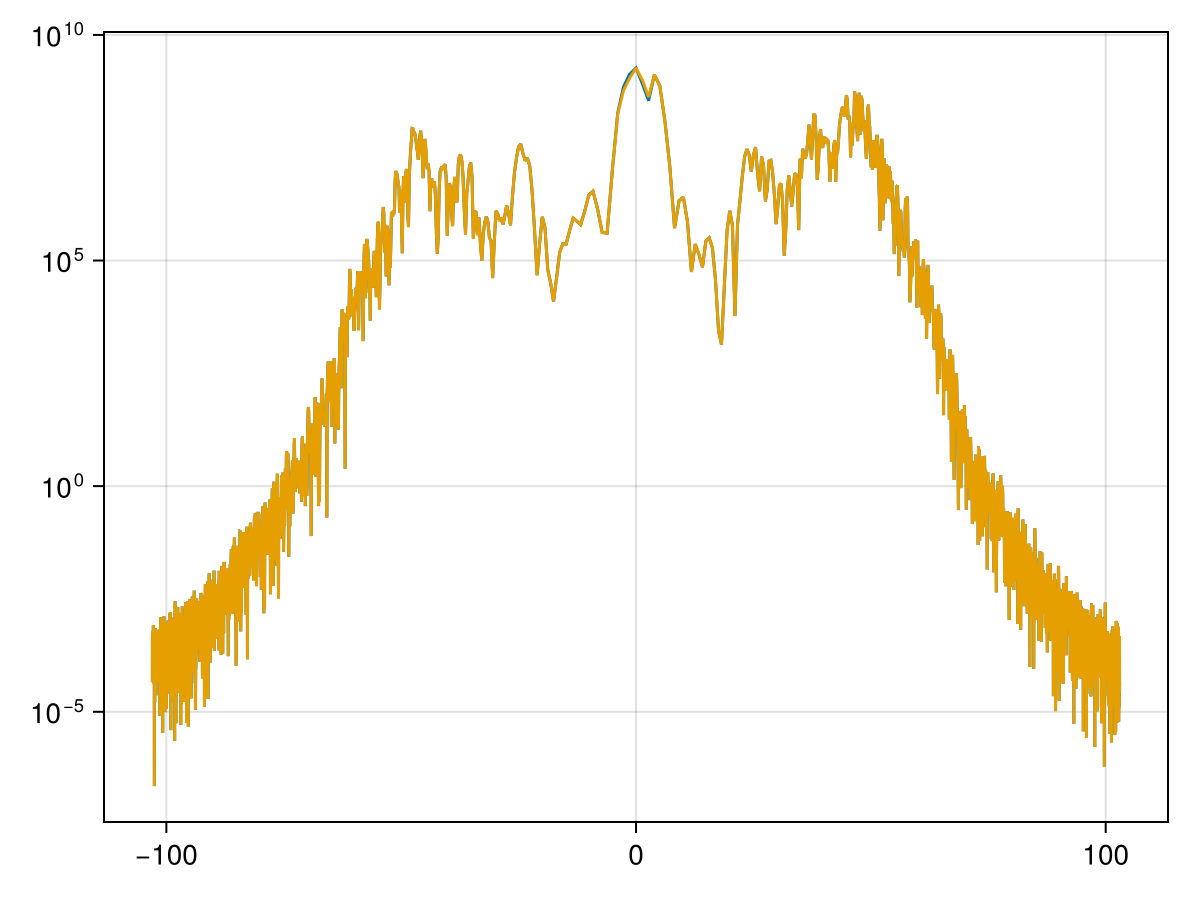

In [72]:
function hann(L)
    ell = L + 1
    N = ell - 1
    n = 0:N
    w = @. 0.5 * (1 - cos.(2*π*n/N))
    return w[1:end-1]
end

function nutall(L)
    a0 = 0.355768
    a1 = 0.487396
    a2 = 0.144232
    a3 = 0.012604
    ell = L + 1
    N = ell - 1
    n = 0:N
    w = @. (a0 - a1*cos(2*π*n/N)
              + a2*cos(4*π*n/N)
              - a3*cos(6*π*n/N))
    return w[1:end-1]
end

function flattopw(L)
    a0 = 0.21557895
    a1 = 0.41663158
    a2 = 0.277263158
    a3 = 0.083578947
    a4 = 0.006947368
    ell = L+1
    
    n = 0:(ell - 1)
    w = @. (a0 - a1*cos(2*π*n/(ell - 1))
              + a2*cos(4*π*n/(ell - 1))
              - a3*cos(6*π*n/(ell - 1))
              + a4*cos(8*π*n/(ell - 1)))
    return w[1:end-1]
end

function demean(data)
    mean = sum(data, dims=1) / size(data, 1)
    return data .- mean
end

function linear_least_squares(t, data)
    tsum = sum(t)
    t2sum = sum(t.^2)
    txsum = sum(t .* data, dims=1)
    N = size(t,1)
    slope = (N * (txsum)) / (N * t2sum - tsum.^2)
    intercept = -slope * tsum / N
    return (slope, intercept)
end

function detrend(t, data)
    m, b = linear_least_squares(t, demean(data))
    return data .- m .* t .- b
end

function clean_fft(t, data, window)
    clean_data = detrend(t, data)
    return fft(window .* clean_data, 1)
end

dt = t[3] - t[2]
N = length(t)

window = hann(N-1)
window_2 = nutall(N-1)

cnt = fftshift(fft(cn[2:end], 1), 1)
cnt_2 = fftshift(fft(cn[2:end], 1), 1)

window_cnt = fftshift(fft(window .* cn[2:end], 1), 1)
window_cnt_2 = fftshift(fft(window_2 .* cn[2:end], 1), 1)

clean_cnt = fftshift(clean_fft(t[2:end], cn[2:end], window), 1)
clean_cnt_2 = fftshift(clean_fft(t[2:end], cn[2:end], window_2), 1)

ω = fftshift(fftfreq(N-1, 1/dt)) * 2*pi
ω_2 = fftshift(fftfreq(N-1, 1/dt)) * 2*pi

N_half = Int((N-1)//2)+1
f = Figure()
ax = Axis(f[1,1]; xscale=Makie.pseudolog10, yscale=log10)
#lines!(ax, ω, abs2.(window_cnt))
lines!(ax, ω_2, abs2.(window_cnt_2))
#lines!(ax, ω, abs2.(clean_cnt))
lines!(ax, ω_2, abs2.(clean_cnt_2))

f